<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ данных</a></span></li><li><span><a href="#Модель" data-toc-modified-id="Модель-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Модель</a></span></li></ul></div>

# Восстановление золота из руды

Необходимо подготовить прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Используйте данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Необходимо:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

Для выполнения проекта понадобятся библиотеки *pandas*, *matplotlib* и *sklearn.*

**Описание проекта**

Данные находятся в трёх файлах:
gold_recovery_train_new.csv — обучающая выборка;
gold_recovery_test_new.csv — тестовая выборка;
gold_recovery_full_new.csv — исходные данные.

Данные индексируются датой и временем получения информации (признак date). Соседние по времени параметры часто похожи.
Некоторые параметры недоступны, потому что замеряются и/или рассчитываются значительно позже. Из-за этого в тестовой выборке отсутствуют некоторые признаки, которые могут быть в обучающей. Также в тестовом наборе нет целевых признаков.
Исходный датасет содержит обучающую и тестовую выборки со всеми признаками.
В распоряжении сырые данные: их просто выгрузили из хранилища. Прежде чем приступить к построению модели, необходимо проверить их на корректность.


**Инструкция по выполнению проекта**

1. Подготовить данные
- Открыть файлы и изучить их
- Проверить, что эффективность обогащения рассчитана правильно. Вычислить её на обучающей выборке для признака rougher.output.recovery. Найти MAE между расчётами и значением признака. Сделать выводы.
- Проанализировать признаки, недоступные в тестовой выборке. Что это за параметры? К какому типу относятся?
- Провести предобработку данных.

2. Проанализировать данные
- Посмотреть, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. Сделать выводы.
- Сравнить распределения размеров гранул сырья на обучающей и тестовой выборках. Если распределения сильно отличаются друг от друга, оценка модели будет неправильной.
- Исследовать суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах.

3. Построить модель
- Написать функцию для вычисления итоговой sMAPE.
- Обучить разные модели и оценить их качество кросс-валидацией. Выберать лучшую модель и проверить её на тестовой выборке. Сделать выводы.

**Цель проекта:**

Подготовить прототип модели машинного обучения, которая будет предсказать коэффициент восстановления золота из золотосодержащей руды. Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

## Подготовка данных

Загрузим, изучим и подготовим данные для выполнения проекта. 
Импортируем все необходимые библиотеки и структуры данных в начале проекта.

In [1]:
pip install optuna

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import GridSearchCV, cross_val_score
import optuna

In [3]:
data_train = pd.read_csv('/datasets/gold_recovery_train_new.csv')
data_test = pd.read_csv('/datasets/gold_recovery_test_new.csv')
data_full = pd.read_csv('/datasets/gold_recovery_full_new.csv')

In [4]:
def view(df):
    print('Сводная информация')
    print()
    df.info()
    print()
    print('Числовое описание данных')
    print(df.describe())
    print()
    print('Наличие пропусков')
    print(df.isnull().sum())
    print()
    print('Наличие дубликатов')
    print(df.duplicated().sum())
    print()
    print('Данные ')
    print(display(df))
    return

In [5]:
view(data_train)

Сводная информация

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               1414

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14144,2018-08-18 06:59:59,3.224920,11.356233,6.803482,46.713954,73.755150,8.769645,3.141541,10.403181,1.529220,...,23.031497,-501.167942,20.007571,-499.740028,18.006038,-499.834374,13.001114,-500.155694,20.007840,-501.296428
14145,2018-08-18 07:59:59,3.195978,11.349355,6.862249,46.866780,69.049291,8.897321,3.130493,10.549470,1.612542,...,22.960095,-501.612783,20.035660,-500.251357,17.998535,-500.395178,12.954048,-499.895163,19.968498,-501.041608
14146,2018-08-18 08:59:59,3.109998,11.434366,6.886013,46.795691,67.002189,8.529606,2.911418,11.115147,1.596616,...,23.015718,-501.711599,19.951231,-499.857027,18.019543,-500.451156,13.023431,-499.914391,19.990885,-501.518452
14147,2018-08-18 09:59:59,3.367241,11.625587,6.799433,46.408188,65.523246,8.777171,2.819214,10.463847,1.602879,...,23.024963,-501.153409,20.054122,-500.314711,17.979515,-499.272871,12.992404,-499.976268,20.013986,-500.625471


None


In [6]:
view(data_test)

Сводная информация

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5285,2017-12-31 19:59:59,173.957757,15.963399,8.070000,0.896701,1401.930554,-499.728848,1401.441445,-499.193423,1399.810313,...,13.995957,-500.157454,12.069155,-499.673279,7.977259,-499.516126,5.933319,-499.965973,8.987171,-499.755909
5286,2017-12-31 20:59:59,172.910270,16.002605,8.070000,0.896519,1447.075722,-494.716823,1448.851892,-465.963026,1443.890424,...,16.749781,-496.031539,13.365371,-499.122723,9.288553,-496.892967,7.372897,-499.942956,8.986832,-499.903761
5287,2017-12-31 21:59:59,171.135718,15.993669,8.070000,1.165996,1498.836182,-501.770403,1499.572353,-495.516347,1502.749213,...,19.994130,-499.791312,15.101425,-499.936252,10.989181,-498.347898,9.020944,-500.040448,8.982038,-497.789882
5288,2017-12-31 22:59:59,179.697158,15.438979,8.070000,1.501068,1498.466243,-500.483984,1497.986986,-519.200340,1496.569047,...,19.958760,-499.958750,15.026853,-499.723143,11.011607,-499.985046,9.009783,-499.937902,9.012660,-500.154284


None


In [7]:
view(data_full)

Сводная информация

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               1943

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19434,2018-08-18 06:59:59,3.224920,11.356233,6.803482,46.713954,73.755150,8.769645,3.141541,10.403181,1.529220,...,23.031497,-501.167942,20.007571,-499.740028,18.006038,-499.834374,13.001114,-500.155694,20.007840,-501.296428
19435,2018-08-18 07:59:59,3.195978,11.349355,6.862249,46.866780,69.049291,8.897321,3.130493,10.549470,1.612542,...,22.960095,-501.612783,20.035660,-500.251357,17.998535,-500.395178,12.954048,-499.895163,19.968498,-501.041608
19436,2018-08-18 08:59:59,3.109998,11.434366,6.886013,46.795691,67.002189,8.529606,2.911418,11.115147,1.596616,...,23.015718,-501.711599,19.951231,-499.857027,18.019543,-500.451156,13.023431,-499.914391,19.990885,-501.518452
19437,2018-08-18 09:59:59,3.367241,11.625587,6.799433,46.408188,65.523246,8.777171,2.819214,10.463847,1.602879,...,23.024963,-501.153409,20.054122,-500.314711,17.979515,-499.272871,12.992404,-499.976268,20.013986,-500.625471


None


Проверим, что эффективность обогащения рассчитана правильно. Вычислим её на обучающей выборке для признака rougher.output.recovery. Найдем MAE между расчётами и значением признака.

In [8]:
data_train['recovery'] = (100*(data_train['rougher.output.concentrate_au']*(data_train['rougher.input.feed_au']-data_train['rougher.output.tail_au'])))/(data_train['rougher.input.feed_au']*(data_train['rougher.output.concentrate_au'] - data_train['rougher.output.tail_au']))

In [9]:
data_train[['recovery', 'rougher.output.recovery']].head()

,recovery,rougher.output.recovery
0,87.107763,87.107763
1,86.843261,86.843261
2,86.842308,86.842308
3,87.226430,87.226430
4,86.688794,86.688794


In [10]:
rougher_mae = mean_absolute_error(data_train['rougher.output.recovery'], data_train['recovery'])
print('МАЕ между расчетами и значением признака составляет:', rougher_mae)

МАЕ между расчетами и значением признака составляет: 1.1131451184435918e-14


Значение среднего абсолютного отклонения (МАЕ) низкое, т.е. значения признака рассчитаны верно. 

Проанализируем признаки, недоступные в тестовой выборке. Для этого напишем цикл, который покажет каких признаков нет в тестовой выборке.

In [11]:
print('Признаки, которые отсутствуют в тестовой выборке:')
print()
signs = []
for column in data_train.columns:
    if column not in data_test.columns:
        signs.append(column)
        print (column)

Признаки, которые отсутствуют в тестовой выборке:

final.output.concentrate_ag
final.output.concentrate_pb
final.output.concentrate_sol
final.output.concentrate_au
final.output.recovery
final.output.tail_ag
final.output.tail_pb
final.output.tail_sol
final.output.tail_au
primary_cleaner.output.concentrate_ag
primary_cleaner.output.concentrate_pb
primary_cleaner.output.concentrate_sol
primary_cleaner.output.concentrate_au
primary_cleaner.output.tail_ag
primary_cleaner.output.tail_pb
primary_cleaner.output.tail_sol
primary_cleaner.output.tail_au
rougher.calculation.sulfate_to_au_concentrate
rougher.calculation.floatbank10_sulfate_to_au_feed
rougher.calculation.floatbank11_sulfate_to_au_feed
rougher.calculation.au_pb_ratio
rougher.output.concentrate_ag
rougher.output.concentrate_pb
rougher.output.concentrate_sol
rougher.output.concentrate_au
rougher.output.recovery
rougher.output.tail_ag
rougher.output.tail_pb
rougher.output.tail_sol
rougher.output.tail_au
secondary_cleaner.output.tail_ag


В тестовой выборке отсутствуют целевые признаки (final.output.recovery и rougher.output.recovery) и некоторые параметры, потому что замеряются и/или рассчитываются значительно позже (об этом знаем из описания проекта).

Тип данных - float64.

Проведем предобработку данных. 
Изменим тип данных в data на datatime.

In [12]:
data_train['date'] = pd.to_datetime(data_train['date'], format='%Y-%m-%d %H:%M:%S')
data_test['date'] = pd.to_datetime(data_test['date'], format='%Y-%m-%d %H:%M:%S')
data_full['date'] = pd.to_datetime(data_full['date'], format='%Y-%m-%d %H:%M:%S')

In [13]:
pd.set_option('display.max_rows', 100)

In [14]:
data_train.isnull().sum().sort_values(ascending=True)

date                                                     0
rougher.input.feed_ag                                    0
rougher.input.feed_au                                    0
rougher.output.concentrate_ag                            0
rougher.output.concentrate_pb                            0
rougher.output.concentrate_au                            0
rougher.output.recovery                                  0
rougher.output.tail_pb                                   0
rougher.output.tail_sol                                  0
rougher.output.tail_au                                   0
rougher.state.floatbank10_d_air                          0
rougher.state.floatbank10_d_level                        0
rougher.state.floatbank10_e_level                        0
rougher.state.floatbank10_f_air                          0
rougher.state.floatbank10_f_level                        0
secondary_cleaner.output.tail_au                         0
rougher.calculation.au_pb_ratio                         

In [15]:
data_test = data_test.merge(data_full[['date','rougher.output.recovery', 'final.output.recovery']], on='date')

In [16]:
data_train = data_train.fillna(method='ffill')
data_test = data_test.fillna(method='ffill')
data_full = data_full.fillna(method='ffill')

In [17]:
data_full.isnull().sum().sort_values(ascending=True)

date                                                  0
rougher.state.floatbank10_e_level                     0
rougher.state.floatbank10_e_air                       0
rougher.state.floatbank10_d_level                     0
rougher.state.floatbank10_d_air                       0
rougher.state.floatbank10_c_level                     0
rougher.state.floatbank10_c_air                       0
rougher.state.floatbank10_b_level                     0
rougher.state.floatbank10_b_air                       0
rougher.state.floatbank10_f_air                       0
rougher.state.floatbank10_a_level                     0
rougher.output.tail_au                                0
rougher.output.tail_sol                               0
rougher.output.tail_pb                                0
rougher.output.tail_ag                                0
rougher.output.recovery                               0
rougher.output.concentrate_au                         0
rougher.output.concentrate_sol                  

# Вывод по шагу 1
1. Открыли и изучили 3 датафрейма data_train, data_test и data_full.
2. Все датафреймы имеют пропуски, поскольку данные могут записываться или рассчитываться позже.
3. В датафейме data_test отсутствуют некоторые признаки, в том числе целевые - final.output.recovery и rougher.output.recovery
4. Дубликатов нет.
5. Провели предобработку данных:
    - Изменили во всех датафреймах тип данных в 'date' на datatime
    - Удалили пропуски в целевых признаках из обучающей выборке

## Анализ данных

Посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки.

Для начала определимся с какими признаками будем работать.

1. Параметры сырья до флотации
    - rougher.input.feed_au
    - rougher.input.feed_ag
    - rougher.input.feed_pb


2. Параметры продукта после флотации
    - rougher.output.concentrate_au
    - rougher.output.concentrate_ag
    - rougher.output.concentrate_pb
    
    
3. Параметры продукта после первичной очистки
    - primary_cleaner.output.concentrate_au
    - primary_cleaner.output.concentrate_ag
    - primary_cleaner.output.concentrate_pb
    

4. Финальные характеристики продукта
    - final.output.concentrate_au
    - final.output.concentrate_ag
    - final.output.concentrate_pb

Объеденим необходимые признаки по группам для дальнейшего удобства работы с ними

In [18]:
concentrate_au = ['rougher.input.feed_au', 'rougher.output.concentrate_au', 
                  'primary_cleaner.output.concentrate_au', 'final.output.concentrate_au']
concentrate_ag = ['rougher.input.feed_ag', 'rougher.output.concentrate_ag', 
                  'primary_cleaner.output.concentrate_ag', 'final.output.concentrate_ag']
concentrate_pb = ['rougher.input.feed_pb', 'rougher.output.concentrate_pb', 
                  'primary_cleaner.output.concentrate_pb', 'final.output.concentrate_pb']
concentrate_sol = ['rougher.input.feed_sol', 'rougher.output.concentrate_sol', 
                  'primary_cleaner.output.concentrate_sol', 'final.output.concentrate_sol']

Создадим функцию, которая будет строить боксплот с признаками по различным этапам обработки

In [19]:
def box(concentrate,metal):
    sns.boxplot(data=data_train[concentrate], orient="h")
    print('Концентрация '+ metal+ ' на этапах обработки')
    return

Концентрация золота на этапах обработки


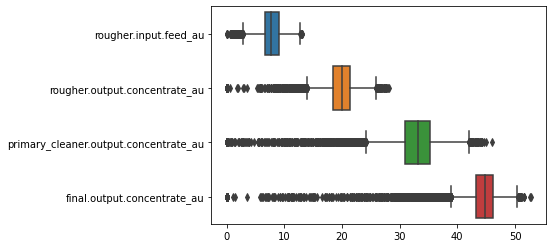

In [20]:
box(concentrate_au, 'золота')

Концентрация серебра на этапах обработки


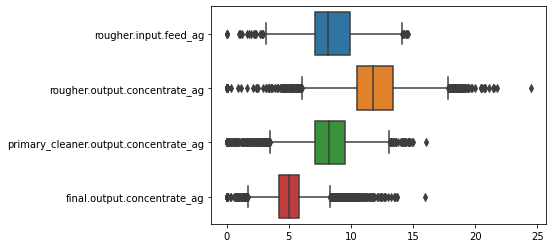

In [21]:
box(concentrate_ag, 'серебра')

Концентрация свинца на этапах обработки


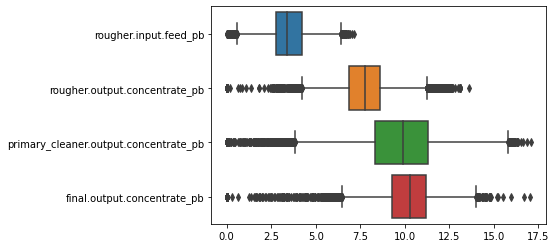

In [22]:
box(concentrate_pb, 'свинца')

Из графиков видно, что с каждым последующим этапом обработки концентрация золота увеличивается, а концентрация серебра и свинца снижается. Для наглядности построим еще plot.

Параметры сырья до флотации


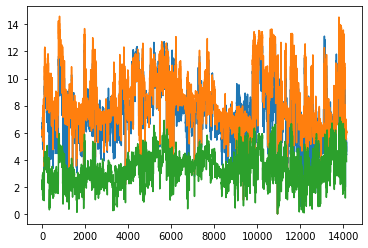

In [23]:
def plotter():
    plt.plot(data_train['rougher.input.feed_au'])
    plt.plot(data_train['rougher.input.feed_ag'])
    plt.plot(data_train['rougher.input.feed_pb'])
    print('Параметры сырья до флотации')
    plt.show()
plotter()

Параметры продукта после флотации


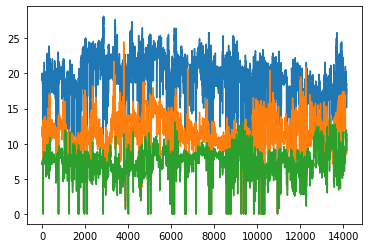

In [24]:
def plotter():
    plt.plot(data_train['rougher.output.concentrate_au'])
    plt.plot(data_train['rougher.output.concentrate_ag'])
    plt.plot(data_train['rougher.output.concentrate_pb'])
    print('Параметры продукта после флотации')
    plt.show()
plotter()

Параметры продукта после первичной очистки


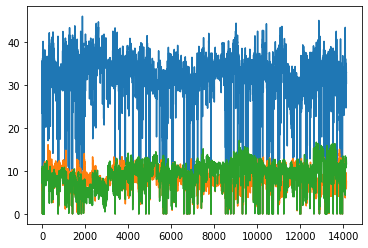

In [25]:
def plotter():
    plt.plot(data_train['primary_cleaner.output.concentrate_au'])
    plt.plot(data_train['primary_cleaner.output.concentrate_ag'])
    plt.plot(data_train['primary_cleaner.output.concentrate_pb'])
    print('Параметры продукта после первичной очистки')
    plt.show()
plotter()

Финальные характеристики продукта


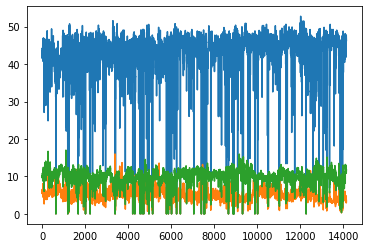

In [26]:
def plotter():
    plt.plot(data_train['final.output.concentrate_au'])
    plt.plot(data_train['final.output.concentrate_ag'])
    plt.plot(data_train['final.output.concentrate_pb'])
    print('Финальные характеристики продукта')
    plt.show()
    
plotter()

In [27]:
print('Средняя концентрация металлов до флотации:')
print('Золото', round(data_train['rougher.input.feed_au'].mean(), 2))
print('Серебро', round(data_train['rougher.input.feed_ag'].mean(),2))
print('Свинец', round(data_train['rougher.input.feed_pb'].mean(),2))

Средняя концентрация металлов до флотации:
Золото 7.87
Серебро 8.58
Свинец 3.51


In [28]:
print('Средняя концентрация металлов после флотации:')
print('Золото', round(data_train['rougher.output.concentrate_au'].mean(), 2))
print('Серебро', round(data_train['rougher.output.concentrate_ag'].mean(),2))
print('Свинец', round(data_train['rougher.output.concentrate_pb'].mean(),2))

Средняя концентрация металлов после флотации:
Золото 19.44
Серебро 11.78
Свинец 7.66


In [29]:
print('Средняя концентрация металлов после первичной очистки:')
print('Золото', round(data_train['primary_cleaner.output.concentrate_au'].mean(), 2))
print('Серебро', round(data_train['primary_cleaner.output.concentrate_ag'].mean(),2))
print('Свинец', round(data_train['primary_cleaner.output.concentrate_pb'].mean(),2))

Средняя концентрация металлов после первичной очистки:
Золото 32.39
Серебро 8.2
Свинец 9.57


In [30]:
print('Средняя концентрация металлов после вторичной очистки:')
print('Золото', round(data_train['final.output.concentrate_au'].mean(), 2))
print('Серебро', round(data_train['final.output.concentrate_ag'].mean(),2))
print('Свинец', round(data_train['final.output.concentrate_pb'].mean(),2))

Средняя концентрация металлов после вторичной очистки:
Золото 44.0
Серебро 5.14
Свинец 10.13


Действительно, с каждым последующим этапом обработки концентрация золота увеличивается, а концентрация серебра и свинца снижается. Интересно, что среднее содержание свинца увеличивается с каждым последующем этапом.

Сравним распределение размеров гранул сырья на обучающей и тестовой выборках. Если распределения сильно отличаются друг от друга, оценка модели будет неправильной.

In [31]:
train_rougher = data_train['rougher.input.feed_size']
test_rougher = data_test['rougher.input.feed_size']
train_primary = data_train['primary_cleaner.input.feed_size']
test_primary = data_test['primary_cleaner.input.feed_size']

In [32]:
def plot(train, test):
    alpha = 0.70
    bins = 50
    _, ax = plt.subplots(1, figsize=(15, 7))
    train.hist(bins=bins, color='lightgray', ax=ax, alpha=alpha) 
    test.hist(bins=bins, color='orange', ax=ax, alpha=alpha) 
    plt.ylim(0,6000)
    plt.xlim(0,175)
    plt.suptitle('Размер гранул до флотации')
    plt.show()
    print('Средний размер гранул обучающая выборка', train.mean())
    print('Средний размер гранул тестовая выборка', test.mean())
    print('Средний размер гранул обучающая выборка', train.median())
    print('Средний размер гранул обучающая выборка', test.median())

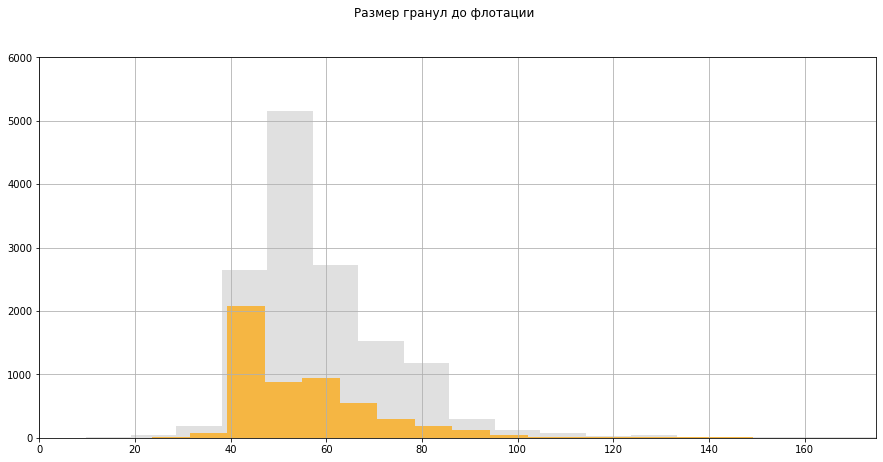

Средний размер гранул обучающая выборка 60.23985599255732
Средний размер гранул тестовая выборка 55.952754028895136
Средний размер гранул обучающая выборка 55.269783890501536
Средний размер гранул обучающая выборка 50.8468431600362


In [33]:
plot(train_rougher, test_rougher)

In [34]:
def plot_2(train_2, test_2):
    alpha = 0.70
    bins = 50
    _, ax = plt.subplots(1, figsize=(15, 7))
    train_2.hist(bins=bins, color='lightgray', ax=ax, alpha=alpha) 
    test_2.hist(bins=bins, color='orange', ax=ax, alpha=alpha) 
    plt.ylim(0,2500)
    plt.xlim(5,11)
    plt.suptitle('Размер гранул после первичной очистки')
    plt.show()
    print('Средний размер гранул обучающая выборка', train_2.mean())
    print('Средний размер гранул тестовая выборка', test_2.mean())
    print('Средний размер гранул обучающая выборка', train_2.median())
    print('Средний размер гранул обучающая выборка', test_2.median())

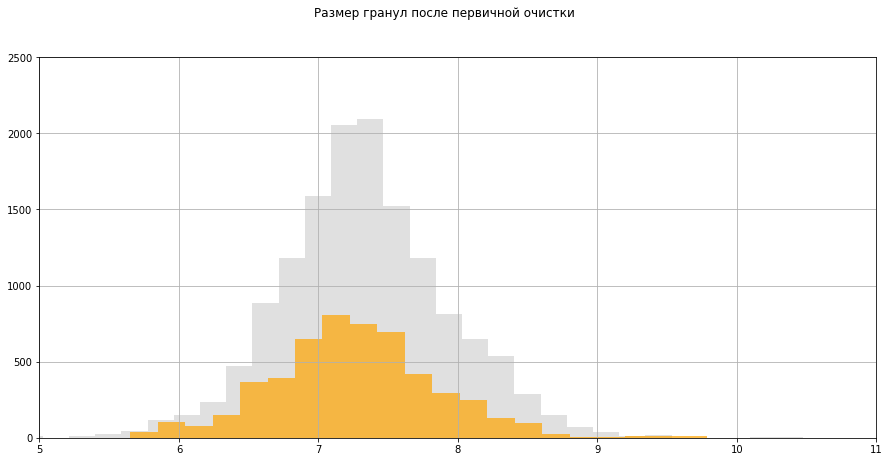

Средний размер гранул обучающая выборка 7.322309906901314
Средний размер гранул тестовая выборка 7.266339191270906
Средний размер гранул обучающая выборка 7.289999961853027
Средний размер гранул обучающая выборка 7.25


In [35]:
plot_2(train_primary, test_primary)

На графиках видно, что размер гранул и распределение различаются на обучающей и тестовой выборке, при этом средние размеры гранул близки по значениям.

Исследуем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. Нам потребуются данные признаков:

- rougher.input.feed_ 
- rougher.output.concentrate_ 
- primary_cleaner.output.concentrate_
- final.output.concentrate_

In [36]:
sum_concentrate_rougher_input = ['rougher.input.feed_au','rougher.input.feed_ag','rougher.input.feed_pb',
                                 'rougher.input.feed_sol']
sum_concentrate_rougher_output = ['rougher.output.concentrate_au','rougher.output.concentrate_ag',
                                  'rougher.output.concentrate_pb','rougher.output.concentrate_sol']
sum_concentrate_primary = ['primary_cleaner.output.concentrate_au','primary_cleaner.output.concentrate_ag',
                           'primary_cleaner.output.concentrate_pb','primary_cleaner.output.concentrate_sol']
sum_concentrate_final = ['final.output.concentrate_au','final.output.concentrate_ag', 
                         'final.output.concentrate_sol','final.output.concentrate_pb']

In [37]:
def box_2(sum_concentrate, stage):
    sns.boxplot(data=data_train[sum_concentrate].sum(), orient="h")
    print('Концентрация '+stage)
    return

Концентрация сырья на этапе флотации


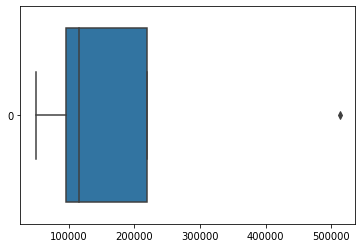

In [38]:
box_2(sum_concentrate_rougher_input, 'сырья на этапе флотации')

Концентрация продукта на этапе флотации


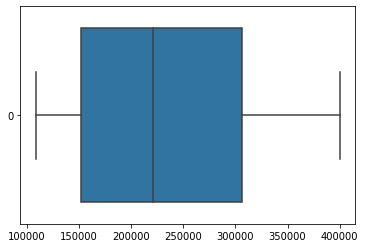

In [39]:
box_2(sum_concentrate_rougher_output, 'продукта на этапе флотации')

Концентрация после первичной очистки


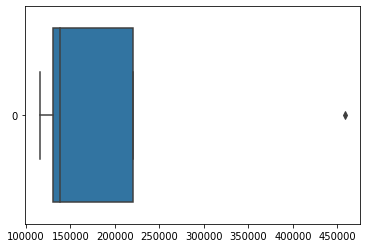

In [40]:
box_2(sum_concentrate_primary,'после первичной очистки' )

Концентрация на финальном этапе


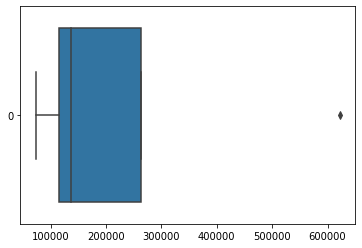

In [41]:
box_2(sum_concentrate_final, 'на финальном этапе')

На боксплота видно, что суммарно концентрация всех веществ уменьшается в финале. После первичной очистки и на финальном этапе присутствуют выбросы. Из-за того, что выбросы могут искажать визуальные данные, посмотрим на суммарную конценртацию на одной гистограмме. Для этого создадим датафрейм с суммарными концентрациями веществ.

In [42]:
total_concentrate = data_train.loc[:,(concentrate_au+concentrate_ag+concentrate_pb+concentrate_sol)]
total_concentrate

,rougher.input.feed_au,rougher.output.concentrate_au,primary_cleaner.output.concentrate_au,final.output.concentrate_au,rougher.input.feed_ag,rougher.output.concentrate_ag,primary_cleaner.output.concentrate_ag,final.output.concentrate_ag,rougher.input.feed_pb,rougher.output.concentrate_pb,primary_cleaner.output.concentrate_pb,final.output.concentrate_pb,rougher.input.feed_sol,rougher.output.concentrate_sol,primary_cleaner.output.concentrate_sol,final.output.concentrate_sol
0,6.486150,19.793808,34.174427,42.192020,6.100378,11.500771,8.547551,6.055403,2.284912,7.101074,10.389648,9.889648,36.808594,28.029297,19.529297,5.507324
1,6.478583,20.050975,34.118526,42.701629,6.161113,11.615865,8.558743,6.029369,2.266033,7.278807,10.497069,9.968944,35.753385,28.067063,19.369147,5.257781
2,6.362222,19.737170,33.969464,42.657501,6.116455,11.695753,8.603505,6.055926,2.159622,7.216833,10.354494,10.213995,35.971630,27.454037,19.167579,5.383759
3,6.118189,19.320810,28.260743,42.689819,6.043309,11.915047,7.221879,6.047977,2.037807,7.175616,8.496563,9.977019,36.862241,27.341277,15.978538,4.858634
4,5.663707,19.216101,33.044932,42.774141,6.060915,12.411054,9.089428,6.148599,1.786875,7.240205,9.986786,10.142511,34.347666,27.041023,19.199864,4.939416
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14144,5.335862,18.603550,32.940215,46.713954,6.091855,11.124896,6.559174,3.224920,4.617558,10.984003,12.445966,11.356233,37.369774,30.068876,7.056338,6.803482
14145,4.838619,18.441436,32.925325,46.866780,6.121323,11.425983,6.612376,3.195978,4.144989,10.888213,12.623947,11.349355,38.591551,29.783972,7.542264,6.862249
14146,4.525061,15.111231,31.856742,46.795691,5.970515,8.523497,7.128896,3.109998,4.020002,8.955135,12.633558,11.434366,40.074026,22.786467,7.941900,6.886013
14147,4.362781,17.834772,30.770892,46.408188,6.048130,11.658799,7.490444,3.367241,3.902537,10.655377,12.012378,11.625587,39.713906,29.052742,6.942972,6.799433


In [43]:
def total(stage):
    total_concentrate['total_'+stage] = (total_concentrate[stage+'_au']+total_concentrate[stage+'_ag']
                                         +total_concentrate[stage+'_pb']+total_concentrate[stage+'_sol'])

In [44]:
stages = ['rougher.input.feed', 'rougher.output.concentrate', 'primary_cleaner.output.concentrate','final.output.concentrate']
for stage in stages:
    total(stage)

In [45]:
total_concentrate.head()

,rougher.input.feed_au,rougher.output.concentrate_au,primary_cleaner.output.concentrate_au,final.output.concentrate_au,rougher.input.feed_ag,rougher.output.concentrate_ag,primary_cleaner.output.concentrate_ag,final.output.concentrate_ag,rougher.input.feed_pb,rougher.output.concentrate_pb,primary_cleaner.output.concentrate_pb,final.output.concentrate_pb,rougher.input.feed_sol,rougher.output.concentrate_sol,primary_cleaner.output.concentrate_sol,final.output.concentrate_sol,total_rougher.input.feed,total_rougher.output.concentrate,total_primary_cleaner.output.concentrate,total_final.output.concentrate
0,6.486150,19.793808,34.174427,42.192020,6.100378,11.500771,8.547551,6.055403,2.284912,7.101074,10.389648,9.889648,36.808594,28.029297,19.529297,5.507324,51.680034,66.424950,72.640924,63.644396
1,6.478583,20.050975,34.118526,42.701629,6.161113,11.615865,8.558743,6.029369,2.266033,7.278807,10.497069,9.968944,35.753385,28.067063,19.369147,5.257781,50.659114,67.012710,72.543485,63.957723
2,6.362222,19.737170,33.969464,42.657501,6.116455,11.695753,8.603505,6.055926,2.159622,7.216833,10.354494,10.213995,35.971630,27.454037,19.167579,5.383759,50.609929,66.103793,72.095042,64.311180
3,6.118189,19.320810,28.260743,42.689819,6.043309,11.915047,7.221879,6.047977,2.037807,7.175616,8.496563,9.977019,36.862241,27.341277,15.978538,4.858634,51.061546,65.752751,59.957723,63.573449
4,5.663707,19.216101,33.044932,42.774141,6.060915,12.411054,9.089428,6.148599,1.786875,7.240205,9.986786,10.142511,34.347666,27.041023,19.199864,4.939416,47.859163,65.908382,71.321010,64.004667


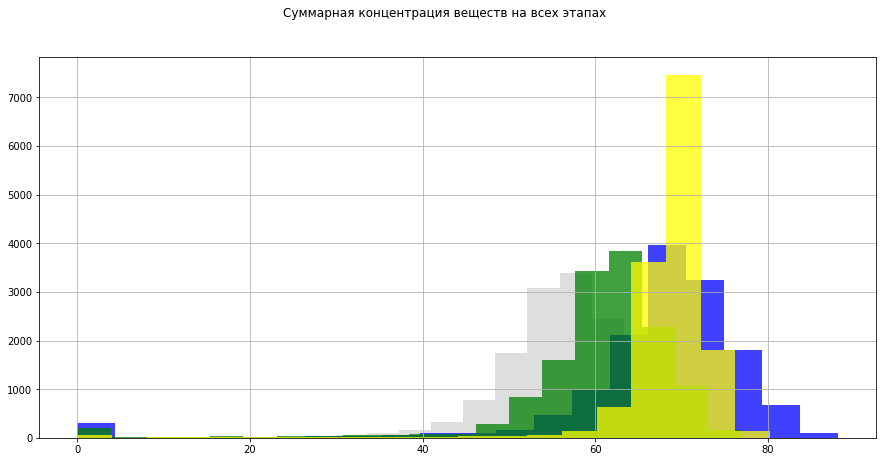

In [46]:
alpha = 0.75
bins = 20
_, ax = plt.subplots(1, figsize=(15, 7))
total_concentrate['total_rougher.input.feed'].hist(bins=bins, color='lightgray', ax=ax, alpha=alpha, label='сырьё')
total_concentrate['total_rougher.output.concentrate'].hist(bins=bins, color='blue', ax=ax, alpha=alpha)
total_concentrate['total_primary_cleaner.output.concentrate'].hist(bins=bins, color='green', ax=ax, alpha=alpha, label='сырьё')
total_concentrate['total_final.output.concentrate'].hist(bins=bins, color='yellow', ax=ax, alpha=alpha, label='сырьё')
plt.suptitle('Суммарная концентрация веществ на всех этапах')
plt.show()

На всех этапах присутствуют нулевые значения, удалим их, поскольку это выбросы.

In [47]:
data_train=data_train.drop(data_train[data_train["rougher.input.feed_au"]<1].index, axis=0)
data_train=data_train.drop(index=data_train[data_train["rougher.input.feed_ag"]<1].index, axis=0)
data_train=data_train.drop(index=data_train[data_train["rougher.input.feed_pb"]<1].index, axis=0)
data_train=data_train.drop(index=data_train[data_train["rougher.output.concentrate_au"]<1].index, axis=0)
data_train=data_train.drop(index=data_train[data_train["rougher.output.concentrate_ag"]<1].index, axis=0)
data_train=data_train.drop(index=data_train[data_train["rougher.output.concentrate_pb"]<1].index, axis=1)
data_train=data_train.drop(index=data_train[data_train["primary_cleaner.output.concentrate_au"]<1].index, axis=0)
data_train=data_train.drop(index=data_train[data_train["primary_cleaner.output.concentrate_ag"]<1].index, axis=0)
data_train=data_train.drop(index=data_train[data_train["primary_cleaner.output.concentrate_pb"]<1].index, axis=0)
data_train=data_train.drop(index=data_train[data_train["final.output.concentrate_au"]<1].index, axis=0)
data_train=data_train.drop(index=data_train[data_train["final.output.concentrate_ag"]<1].index, axis=0)
data_train=data_train.drop(index=data_train[data_train["final.output.concentrate_pb"]<1].index, axis=0)

In [48]:
(data_train["primary_cleaner.output.concentrate_au"]==0).sum()

0

In [49]:
total_concentrate = data_train.loc[:, (concentrate_au+concentrate_ag+concentrate_pb+concentrate_sol)]

def total(stage):
    total_concentrate['total_'+stage] = (total_concentrate[stage+'_au']+total_concentrate[stage+'_ag']+total_concentrate[stage+'_pb']+total_concentrate[stage+'_sol'])

stages = ['rougher.input.feed', 'rougher.output.concentrate', 'primary_cleaner.output.concentrate','final.output.concentrate']
for stage in stages:
    total(stage)

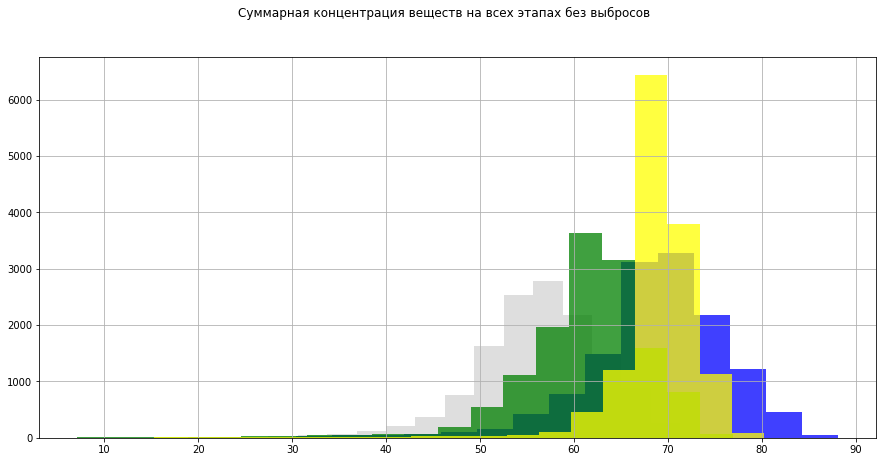

In [50]:
alpha = 0.75
bins = 20
_, ax = plt.subplots(1, figsize=(15, 7))
total_concentrate['total_rougher.input.feed'].hist(bins=bins, color='lightgray', ax=ax, alpha=alpha, label='сырьё')
total_concentrate['total_rougher.output.concentrate'].hist(bins=bins, color='blue', ax=ax, alpha=alpha)
total_concentrate['total_primary_cleaner.output.concentrate'].hist(bins=bins, color='green', ax=ax, alpha=alpha, label='сырьё')
total_concentrate['total_final.output.concentrate'].hist(bins=bins, color='yellow', ax=ax, alpha=alpha, label='сырьё')
plt.suptitle('Суммарная концентрация веществ на всех этапах без выбросов')
plt.show()

# Вывод по шагу 2
 
Размер гранул и распределение различается на обучающей и тестовой выборке.   
Данные о концентрации веществ содержат околонулевые значения, которые были удалены.  
Суммарно концентрация золота увеличивается, а концентрация серебра и свинца уменьшаятся с каждым этапом.

## Модель

Напишем функцию для вычисления итоговой sMAPE и зададим метрику score.

In [51]:
def sMAPE(target, predict):
    error = np.mean(abs(target - predict)/((abs(target)+abs(predict))/2))*100
    return error

In [52]:
def final_sMAPE(sMAPE_rougher,sMAPE_final):
    return (0.25*sMAPE_rougher + 0.75*sMAPE_final)

In [53]:
score = make_scorer(sMAPE, greater_is_better=False)

In [54]:
rougher_features = ['rougher.input.feed_ag', 
                    'rougher.input.feed_pb',
                    'rougher.input.feed_rate',
                    'rougher.input.feed_size',
                    'rougher.input.feed_sol',
                    'rougher.input.feed_au',
                    'rougher.input.floatbank10_sulfate',
                    'rougher.input.floatbank10_xanthate',
                    'rougher.input.floatbank11_sulfate',
                    'rougher.input.floatbank11_xanthate',
                    'rougher.state.floatbank10_a_air',
                    'rougher.state.floatbank10_a_level',
                    'rougher.state.floatbank10_b_air',
                    'rougher.state.floatbank10_b_level',
                    'rougher.state.floatbank10_c_air',
                    'rougher.state.floatbank10_c_level',
                    'rougher.state.floatbank10_d_air',
                    'rougher.state.floatbank10_d_level',
                    'rougher.state.floatbank10_e_air',
                    'rougher.state.floatbank10_e_level',
                    'rougher.state.floatbank10_f_air',
                    'rougher.state.floatbank10_f_level'] 

In [55]:
cols = [ c for c in data_train if c in data_test ]
clean_train = data_train[cols]

In [56]:
clean_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13436 entries, 0 to 14148
Data columns (total 55 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   date                                        13436 non-null  datetime64[ns]
 1   final.output.recovery                       13436 non-null  float64       
 2   primary_cleaner.input.sulfate               13436 non-null  float64       
 3   primary_cleaner.input.depressant            13436 non-null  float64       
 4   primary_cleaner.input.feed_size             13436 non-null  float64       
 5   primary_cleaner.input.xanthate              13436 non-null  float64       
 6   primary_cleaner.state.floatbank8_a_air      13436 non-null  float64       
 7   primary_cleaner.state.floatbank8_a_level    13436 non-null  float64       
 8   primary_cleaner.state.floatbank8_b_air      13436 non-null  float64       
 9   primar

In [57]:
features_train = clean_train.drop(['date','rougher.output.recovery', 'final.output.recovery'], axis=1)
target_train_rougher = clean_train['rougher.output.recovery']
target_train_final = clean_train['final.output.recovery']

In [58]:
features_test = data_test.drop(['date','rougher.output.recovery', 'final.output.recovery'], axis=1)
target_test_rougher = data_test.loc[:,'rougher.output.recovery']
target_test_final = data_test.loc[:,'final.output.recovery']

In [59]:
features_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13436 entries, 0 to 14148
Data columns (total 52 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner.input.sulfate               13436 non-null  float64
 1   primary_cleaner.input.depressant            13436 non-null  float64
 2   primary_cleaner.input.feed_size             13436 non-null  float64
 3   primary_cleaner.input.xanthate              13436 non-null  float64
 4   primary_cleaner.state.floatbank8_a_air      13436 non-null  float64
 5   primary_cleaner.state.floatbank8_a_level    13436 non-null  float64
 6   primary_cleaner.state.floatbank8_b_air      13436 non-null  float64
 7   primary_cleaner.state.floatbank8_b_level    13436 non-null  float64
 8   primary_cleaner.state.floatbank8_c_air      13436 non-null  float64
 9   primary_cleaner.state.floatbank8_c_level    13436 non-null  float64
 10  primary_cl

In [60]:
print(features_train.shape)
print(target_train_rougher.shape)
print(target_train_final.shape)
print(features_test.shape)
print(target_test_rougher.shape)
print(target_test_final.shape)

(13436, 52)
(13436,)
(13436,)
(5290, 52)
(5290,)
(5290,)


Подберем парметры с помощью optuna.

In [61]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 1000, 100)
    max_depths = trial.suggest_int('max_depth', 3, 10, step=2)
    clf = RandomForestRegressor(n_estimators=n_estimators,
                                 max_depth=max_depths,
                                 n_jobs=-1)
    score_optuna = cross_val_score(clf, features_train, target_train_final, scoring=score).mean()
    return score_optuna

In [63]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2022-09-28 17:26:58,506] A new study created in memory with name: no-name-5fddee1c-932e-4298-9dbc-87cd6849138d
/opt/conda/lib/python3.9/site-packages/optuna/distributions.py:683: UserWarning: The distribution is specified by [3, 10] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 9].
  warnings.warn(
[I 2022-09-28 17:46:10,183] Trial 0 finished with value: -9.120523200572908 and parameters: {'n_estimators': 800, 'max_depth': 9}. Best is trial 0 with value: -9.120523200572908.
/opt/conda/lib/python3.9/site-packages/optuna/distributions.py:683: UserWarning: The distribution is specified by [3, 10] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 9].
  warnings.warn(
[I 2022-09-28 17:48:09,017] Trial 1 finished with value: -9.107518393965988 and parameters: {'n_estimators': 100, 'max_depth': 7}. Best is trial 1 with value: -9.107518393965988.
/opt/conda/lib/python3.9/site-packages/optuna/distributions.py:683: UserWarning:

In [64]:
print(study.best_params)

{'n_estimators': 200, 'max_depth': 3}


In [65]:
for key, value in study.best_trial.params.items():
    print(f'{key}: {value}')

n_estimators: 200
max_depth: 3


Посмотрим среднюю оценку качества модели на DecisionTreeRegressor с помощью cross_val_score

In [66]:
model_dtr = DecisionTreeRegressor(random_state=12345)

scores_rougher = cross_val_score(model_dtr, features_train, target_train_rougher, scoring=score, cv=5)
final_score_rougher = pd.Series(scores_rougher).mean()

scores_final = cross_val_score(model_dtr, features_train, target_train_final, scoring=score, cv=5)
final_score_final = pd.Series(scores_final).mean()


print('Средняя оценка качества модели DecisionTreeRegressor для rougher:', final_score_rougher)
print('Средняя оценка качества модели DecisionTreeRegressor для final:', final_score_final)

Средняя оценка качества модели DecisionTreeRegressor для rougher: -8.500670123433324
Средняя оценка качества модели DecisionTreeRegressor для final: -15.18641970207884


In [67]:
print('Финальный sMAPE DecisionTreeRegressor', final_sMAPE(final_score_rougher,final_score_final))

Финальный sMAPE DecisionTreeRegressor -13.514982307417462


Посмотрим среднюю оценку качества модели на LinearRegression с помощью cross_val_score

In [68]:
model_lr = LinearRegression()

scores_lr_rougher = cross_val_score(model_lr, features_train, target_train_rougher, scoring=score, cv=5)
final_score_lr_rougher = pd.Series(scores_lr_rougher).mean()

scores_lr_final = cross_val_score(model_lr, features_train, target_train_final, scoring=score, cv=5)
final_score_lr_final = pd.Series(scores_lr_final).mean()

print('Средняя оценка качества модели LinearRegression для rougher:', final_score_lr_rougher)
print('Средняя оценка качества модели LinearRegression для final:', final_score_lr_final)

Средняя оценка качества модели LinearRegression для rougher: -7.155059220934669
Средняя оценка качества модели LinearRegression для final: -10.949978643522183


In [69]:
print('Финальный sMAPE LinearRegression', final_sMAPE(final_score_lr_rougher,final_score_lr_final))

Финальный sMAPE LinearRegression -10.001248787875303


Перейдем к модели RandomForestRegressor. Для подбора параметров к этой модели будем использовать GridSearchCV.

In [70]:
model = RandomForestRegressor(random_state=1234)
param_rfr={'max_depth': range(1,5),'n_estimators': range(1,50)}

In [71]:
grid_rougher = GridSearchCV(model, param_grid = param_rfr, scoring=score, n_jobs=-1, cv=3)
grid_final = GridSearchCV(model, param_grid = param_rfr, scoring=score, n_jobs=-1, cv=3)

In [72]:
grid_rougher.fit(features_train, target_train_rougher)
grid_final.fit(features_train, target_train_final)

GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=1234),
             n_jobs=-1,
             param_grid={'max_depth': range(1, 5),
                         'n_estimators': range(1, 50)},
             scoring=make_scorer(sMAPE, greater_is_better=False))

In [73]:
best_params_rougher = grid_rougher.best_params_
best_params_final = grid_final.best_params_

In [74]:
print(best_params_rougher)
print(best_params_final)

{'max_depth': 3, 'n_estimators': 13}
{'max_depth': 1, 'n_estimators': 13}


In [75]:
best_score_rougher = grid_rougher.best_score_
best_score_final = grid_final.best_score_

In [76]:
print('Финальный sMAPE RandomForestRegressor', final_sMAPE(best_score_rougher,best_score_final))

Финальный sMAPE RandomForestRegressor -9.256942729640116


Проверим финальный sMAPE на тестовой выборке

In [77]:
model_dtr = DecisionTreeRegressor(random_state=12345)
model_dtr.fit(features_train, target_train_rougher)
predicted = model_dtr.predict(features_test)
smape_rought = sMAPE(target_test_rougher, predicted)

model_dtr = DecisionTreeRegressor(random_state=12345)
model_dtr.fit(features_train, target_train_final)
predicted = model_dtr.predict(features_test)
smape_final = sMAPE(target_test_final, predicted)

print('sMAPE DecisionTreeRegressor для rougher на тестовой выборке:', smape_rought)
print('sMAPE DecisionTreeRegressor для final на тестовой выборке:', smape_final)
print('Финальный sMAPE DecisionTreeRegressor на тестовой выборке', final_sMAPE(smape_rought,smape_final))

sMAPE DecisionTreeRegressor для rougher на тестовой выборке: 9.900755375663586
sMAPE DecisionTreeRegressor для final на тестовой выборке: 13.280495571978982
Финальный sMAPE DecisionTreeRegressor на тестовой выборке 12.435560522900133


In [78]:
model_lr = LinearRegression()
model_lr.fit(features_train, target_train_rougher)
predicted = model_lr.predict(features_test)
smape_rought_lr = sMAPE(target_test_rougher, predicted)

model_lr = LinearRegression()
model_lr.fit(features_train, target_train_final)
predicted = model_lr.predict(features_test)
smape_final_lr = sMAPE(target_test_final, predicted)

print('sMAPE LinearRegression для rougher на тестовой выборке:', smape_rought_lr)
print('sMAPE LinearRegression для final на тестовой выборке:', smape_final_lr)
print('Финальный sMAPE DecisionTreeRegressor на тестовой выборке', final_sMAPE(smape_rought_lr, smape_final_lr))

sMAPE LinearRegression для rougher на тестовой выборке: 8.587874103097631
sMAPE LinearRegression для final на тестовой выборке: 9.590471818234047
Финальный sMAPE DecisionTreeRegressor на тестовой выборке 9.339822389449942


In [79]:
model_rf = RandomForestRegressor(max_depth=3, n_estimators=13, random_state=12345)
model_rf.fit(features_train, target_train_rougher)
predicted = model_rf.predict(features_test)
smape_rought_rf = sMAPE(target_test_rougher, predicted)

model_rf = RandomForestRegressor(max_depth=1, n_estimators=13, random_state=12345)
model_rf.fit(features_train, target_train_final)
predicted = model_rf.predict(features_test)
smape_final_rf = sMAPE(target_test_final, predicted)

print('sMAPE RandomForestRegressor для rougher на тестовой выборке:', smape_rought_rf)
print('sMAPE RandomForestRegressor для final на тестовой выборке:', smape_final_rf)
print('Финальный sMAPE RandomForestRegressor на тестовой выборке', final_sMAPE(smape_rought_rf, smape_final_rf))

sMAPE RandomForestRegressor для rougher на тестовой выборке: 8.267839314462558
sMAPE RandomForestRegressor для final на тестовой выборке: 9.571410047935283
Финальный sMAPE RandomForestRegressor на тестовой выборке 9.245517364567101


In [83]:
model_rf = RandomForestRegressor(max_depth=3, n_estimators=200, random_state=12345)
model_rf.fit(features_train, target_train_final)
predicted = model_rf.predict(features_test)
smape_final_rf = sMAPE(target_test_final, predicted)

print('sMAPE RandomForestRegressor для final на тестовой выборке:', smape_final_rf)

sMAPE RandomForestRegressor для rougher на тестовой выборке: 8.267839314462558
sMAPE RandomForestRegressor для final на тестовой выборке: 9.589826584823271
Финальный sMAPE RandomForestRegressor на тестовой выборке 9.259329767233092


Сравним полученную модель с константной для оценки адекватности модели. Используем для этого DummyRegressor.

In [80]:
from sklearn.dummy import DummyRegressor

In [81]:
dummy_regressor = DummyRegressor(strategy="mean")
dummy_regressor.fit(features_train, target_train_rougher)
predicted = dummy_regressor.predict(features_test)
smape_rought_dr = sMAPE(target_test_rougher, predicted)

dummy_regressor = DummyRegressor(strategy="mean")
dummy_regressor.fit(features_train, target_train_final)
predicted = dummy_regressor.predict(features_test)
smape_final_dr = sMAPE(target_test_final, predicted)

print('sMAPE DummyRegressor для rougher на тестовой выборке:', smape_rought_dr)
print('sMAPE DummyRegressor для final на тестовой выборке:', smape_final_dr)
print('Финальный sMAPE DummyRegressor на тестовой выборке', final_sMAPE(smape_rought_dr, smape_final_dr))

sMAPE DummyRegressor для rougher на тестовой выборке: 9.034877548711755
sMAPE DummyRegressor для final на тестовой выборке: 10.072893443245594
Финальный sMAPE DummyRegressor на тестовой выборке 9.813389469612133


# Вывод по шагу 3

Проведена подготовка и анализ данных. Проверены расчеты эффективности обогащения на обучающей выборке для признака rougher.output.recovery. Найден MAE между расчётами и значением признака, который подтверждает, что значения признака рассчитаны верно. В тестовой выборке отсутствуют целевые признаки и некоторые параметры, поскольку они замеряются и/или рассчитываются значительно позже. Проведена предобработка данных (заполнены пропуски, изменены типы данных).

Проверена концентрация металлов (Au, Ag, Pb) на различных этапах очистки. Размер гранул и распределение различается на обучающей и тестовой выборке. Данные о концентрации веществ содержат околонулевые значения, которые были удалены. Суммарно концентрация золота увеличивается, а концентрация серебра и свинца уменьшаятся с каждым этапом.

Написана функция для вычисления итоговой sMAPE, которая одинаково учитывает масштаб и целевого признака, и предсказания.
Данные обучены на моделях LinearRegression, DecisionTreeRegressor и RandomForestRegressor. Применены методы кросс-валидации для оценки качества моделей и GridSearchCV для поиска оптимальных гиперпараметров. Произведён отбор признаков для обучения - только те признаки, которые доступны до технологического процесса.

Лучшая модель RandomForestRegressor (итоговое sMAPE - -9.25) , проверена на тестовой выборке(итоговое sMAPE - 9.24).
Проведена оценка адекватности модели на DummyRegressor (итоговое sMAPE - 9.81).